In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import copy
from pathlib import Path
import seaborn as sns
from PIL import Image
from math import sqrt
from tqdm import tqdm

from torch.utils.data import Dataset
from torchvision import transforms
import torch 
from torch import nn 
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import WeightedRandomSampler
import torchvision as tv
from torch.optim import AdamW
from timm.models.layers import trunc_normal_, DropPath

#Semillas de reproducibilidad 
torch.manual_seed(40)
np.random.seed(40)

#Configurar el dispositivo 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#Cargar el conjunto de datos
!git clone https://github.com/dchen236/FairFace

fatal: destination path 'FairFace' already exists and is not an empty directory.


In [ ]:
#Descargar las imagenes de entrenamiento y validación 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G3OaF1I4-Wn09AjctJhxPSzGn_J-xqYC' -O FairFace.zip

In [2]:
#Estructura del set de datos 
print(os.listdir('FairFace/'))

['.git', 'detected_faces', 'dlib_models', 'examples', 'predict.py', 'predict_bbox.py', 'ReadMe', 'README.md', 'test', 'test_imgs.csv', 'test_outputs.csv']


## **DEFINIMOS LA AQUITECTURA DE LA ConvNeXt**

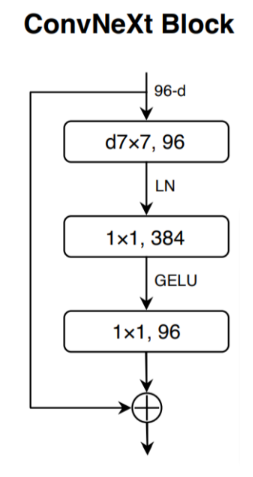

In [3]:
class ConvNeXtRes(nn.Module):
  def __init__(self, in_chan, out_chan, downsample = False, drop_path = 0.):
    super(ConvNeXtRes, self).__init__()
    stride = 1
    if downsample:
      stride =2 
    
    if in_chan != out_chan or downsample:
      self.conv1x1 = nn.Conv2d(in_chan, out_chan, 1, stride = stride)
    else: 
      self.conv1x1 = None
    
    self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size= 7, stride= stride, padding= 3) #Primera convolución 
    self.ln = nn.LayerNorm(out_chan, eps=1e-6) #Layer normalization
    self.conv2 = nn.Conv2d(out_chan, out_chan * 4, kernel_size= 1) #Convolución de expansión 
    self.GeLU = nn.GELU() #Función de activación GeLU
    self.conv3 = nn.Conv2d(out_chan * 4, out_chan, kernel_size = 1) #Convolución de reducción 
    self.gamma = nn.Parameter(1e-6 * torch.ones((out_chan)), requires_grad=True) #tensor de parámetros aprendibles
    self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity() #Activación o desactivación de rutas (similar a droput en MLP)

  def forward(self, x):
  
      # Convolución 1
      y = self.conv1(x)
      # LayerNorm espera la forma (batch_size, height, width, channels)
      y = y.permute(0, 2, 3, 1)
      y = self.ln(y)
      y = y.permute(0, 3, 1, 2)
      #Convolucion 2
      y = self.conv2(y)
      y = self.GeLU(y)
      #Convolucion 3 
      y = self.conv3(y)
      #Aplicar gamma 
      y = self.gamma[:, None, None] * y
      
      #Conexion residual 
      if self.conv1x1:
        x = self.conv1x1(x)
      
      return x + self.drop_path(y) 

In [4]:
res = ConvNeXtRes(3, 16, drop_path=0.5)
output = res(torch.randn(1, 3, 64, 64))
print(output.shape)

torch.Size([1, 16, 64, 64])


In [5]:
#Clase para implementar los bloques ConvNeXtBloq
class ConvNeXtBloq(nn.Module):
    def __init__(self, in_channels, out_channels, k=2, downsample=False, drop_p_list=None):
        super(ConvNeXtBloq, self).__init__()

        if drop_p_list is None:
            drop_p_list = [0.0] * k  # Si no se proporciona, se asume 0.0 para todos los bloques
        assert len(drop_p_list) == k, "La longitud de drop_p_list debe ser igual a k"

        self.res = []
        # Primer bloque (puede aplicar downsampling)
        self.res.append(ConvNeXtRes(in_channels, out_channels, downsample=downsample, drop_path=drop_p_list[0]))

        # Bloques siguientes
        for i in range(1, k):
            self.res.append(ConvNeXtRes(out_channels, out_channels, drop_path=drop_p_list[i]))
        self.res = nn.ModuleList(self.res)

    def forward(self, x):
        for layer in self.res:
            x = layer(x)
        return x

In [6]:
b = ConvNeXtBloq(3, 6)
print(b(torch.rand(1, 3, 64, 64)).shape)

torch.Size([1, 6, 64, 64])


In [7]:
#Función para implementar la arquitectura de la ConvNeXt similar a la ResNet18 
#Se implementan  4 bloques repetidos 2 veces cada uno 
class ConvNeXt50(nn.Module):
    def __init__(self, in_channels, n_clases, drop_path_rate=0.1):
        super(ConvNeXt50, self).__init__()
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=4, stride=4)
        self.ln = nn.LayerNorm(64, eps=1e-6)

        # Definir las profundidades de los bloques
        depths = [2, 2, 2, 2]  # Número de bloques en cada etapa (Similar a la ResNet18)
        total_blocks = sum(depths)
        # Generar las tasas de drop_path para cada bloque
        drop_rates = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]

        # Índice para rastrear la posición en drop_rates
        idx = 0

        # Bloque 1 (siguiendo el tamaño de ResNet18)
        drop_p_list_b1 = drop_rates[idx:idx+depths[0]]
        idx += depths[0]
        self.b1 = ConvNeXtBloq(64, 64, k=depths[0], drop_p_list=drop_p_list_b1)

        # Bloque 2
        drop_p_list_b2 = drop_rates[idx:idx+depths[1]]
        idx += depths[1]
        self.b2 = ConvNeXtBloq(64, 128, k=depths[1], downsample=True, drop_p_list=drop_p_list_b2)

        # Bloque 3
        drop_p_list_b3 = drop_rates[idx:idx+depths[2]]
        idx += depths[2]
        self.b3 = ConvNeXtBloq(128, 256, k=depths[2], downsample=True, drop_p_list=drop_p_list_b3)

        # Bloque 4
        drop_p_list_b4 = drop_rates[idx:idx+depths[3]]
        self.b4 = ConvNeXtBloq(256, 512, k=depths[3], downsample=True, drop_p_list=drop_p_list_b4)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.nom = nn.LayerNorm(512, eps = 1e-6)
        self.densa = nn.Linear(512, n_clases)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln(x.permute(0, 2, 3, 1))
        x = x.permute(0, 3, 1, 2)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.nom(x)
        x = self.densa(x)
        return x

In [8]:
b = ConvNeXt50(in_channels=3, n_clases=7, drop_path_rate=0.1).to(device)
print(b(torch.rand(1, 3, 96, 96).to(device)).shape)

torch.Size([1, 7])


In [8]:
# Obtener el directorio actual donde se está ejecutando el notebook
current_dir = Path.cwd()
#Cargar las rutas del csv para los labels
path_labels_train =current_dir/'fairface-img-margin125-trainval'/'fairface_label_train.csv' #Ruta al CSV de entrenamiento
path_labels_val = current_dir/'fairface-img-margin125-trainval'/'fairface_label_val.csv' #Ruta al CSV de validación 
LOGDIR = current_dir / 'logs' / 'Faces' #Directorio para guardar los logs
ckptpath = LOGDIR / 'ConvNeXt50.pt'

## Definimos la funciones para obtener los datos, para ello usamos el csv que contiene las rutas y etiquetas para el set de entrenamiento y validación

In [9]:
def load_csv(train_path, val_path):
    tqdm.pandas()
     # Cargar el CSV
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    
    
    # Limpiar el csv
    train_df = train_df.drop(columns=['race', 'service_test', 'gender']) #Eliminamos las columnas que no necesitamos
    val_df = val_df.drop(columns=['race', 'service_test', 'gender'])
    
    #ajustar las rutas 
    train_df['file'] = train_df['file'].progress_apply(lambda x: current_dir/'fairface-img-margin125-trainval'/x)
    val_df['file'] = val_df['file'].progress_apply(lambda x: current_dir/'fairface-img-margin125-trainval'/x)
    
    # Convertir la columna 'age' en categoría
    train_df['age'] = train_df['age'].astype('category')
    
    # Crear códigos para las categorías de edad
    train_df['age_code'] = train_df['age'].cat.codes
    
    # Crear un diccionario que mapee categorías a códigos
    age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
    
    # mostrar barra de progreso
    val_df['age_code'] = val_df['age'].progress_apply(lambda x: age_map[x]).astype('int8') 
    
    return train_df, val_df

In [10]:
# Verificar y crear el directorio del checkpoint si no existe
if not ckptpath.parent.exists():
    ckptpath.parent.mkdir(parents=True, exist_ok=True)
    print(f"Directorio creado: {ckptpath.parent}")
else:
    print(f"Directorio existente: {ckptpath.parent}")

Directorio existente: c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\Deep Learning\Tarea 2\logs\Faces


In [11]:
csv_train, csv_val = load_csv(train_path=path_labels_train,val_path=path_labels_val )

100%|██████████| 10954/10954 [00:00<00:00, 2738535.26it/s]


In [12]:
csv_train.dtypes, csv_val.dtypes

(file          object
 age         category
 age_code        int8
 dtype: object,
 file        object
 age         object
 age_code      int8
 dtype: object)

In [13]:
print(f'Total de archivos en entrenamieto: {csv_train.shape[0]}')
print(f'Total de archivos en validacion: {csv_val.shape[0]}')

Total de archivos en entrenamieto: 86744
Total de archivos en validacion: 10954


In [14]:
print('Entrenamiento')
print(f'Total de archivos por etiqueta: {csv_train.groupby(["age_code"]).size()}')
print('\n')
print('Validacion')
print(f'Total de archivos por etiqueta: {csv_val.groupby(["age_code"]).size()}')

Entrenamiento
Total de archivos por etiqueta: age_code
0     1792
1     9103
2    25598
3    10408
4    19250
5    10744
6     6228
7     2779
8      842
dtype: int64


Validacion
Total de archivos por etiqueta: age_code
0     199
1    1181
2    3300
3    1356
4    2330
5    1353
6     796
7     321
8     118
dtype: int64


In [15]:
csv_train.head()

file    age  age_code
0  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  50-59         6
1  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  30-39         4
2  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...    3-9         3
3  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  20-29         2
4  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  20-29         2

## Verificamos las etiquetas de entrenamiento y validación

In [16]:
unique_age_mappings = csv_train[['age', 'age_code']].drop_duplicates().sort_values(by='age')
print(unique_age_mappings)

              age  age_code
18            0-2         0
8           10-19         1
3           20-29         2
2             3-9         3
1           30-39         4
6           40-49         5
0           50-59         6
14          60-69         7
107  more than 70         8


In [17]:
unique_age_mappings_val = csv_val[['age', 'age_code']].drop_duplicates().sort_values(by='age')
print(unique_age_mappings_val)

             age  age_code
44           0-2         0
23         10-19         1
3          20-29         2
0            3-9         3
2          30-39         4
12         40-49         5
1          50-59         6
34         60-69         7
10  more than 70         8


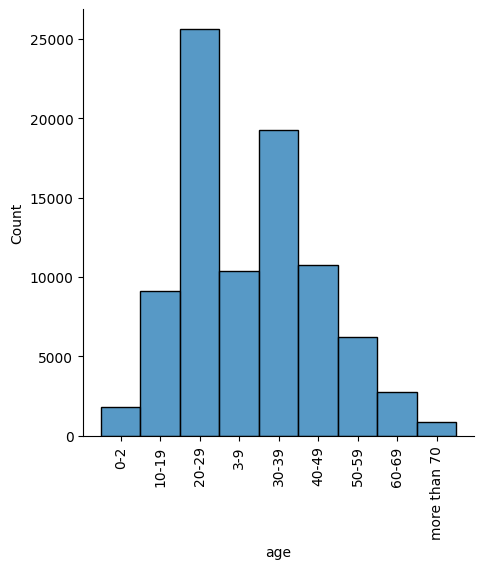

In [18]:
#Graficamos las etiquetas de entrenamiento
sns.displot(csv_train.age)
plt.xticks(rotation=90)
plt.show()

## De la grafica anterior podemos observar que en las etiquetas en el set de entrenamiento se encuentran desbalanceadas para la etiqueta de grupo etario

In [19]:
csv_val.head()

file    age  age_code
0  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...    3-9         3
1  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  50-59         6
2  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  30-39         4
3  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  20-29         2
4  c:\Users\ArMan\OneDrive\Escritorio\IIMAS\3ER\D...  20-29         2

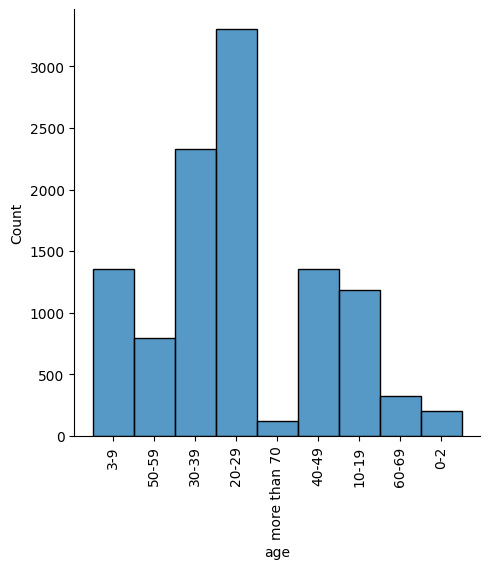

In [20]:
#Graficamos las etiquetas de validacion
sns.displot(csv_val.age)
plt.xticks(rotation=90)
plt.show()

## En el set de validación las clases se encuentran igualmente desvalanceadas para la etiqueta de grupo etario

## **Creamos las clase para el DataLoader**

In [21]:
class FairFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.imgs = df['file'].tolist()
        self.labels = df['age_code'].tolist()
        self.transform = transform
          
    def __len__(self):
        return len(self.imgs)  # Retorna el número de filas en el DataFrame
    
    def __getitem__(self,i):
        img = Image.open(self.imgs[i]).convert('RGB')
        label = torch.tensor(self.labels[i],dtype=torch.long)
         # Aplicar transformaciones a la imagen (si es necesario)
        if self.transform:
            img = self.transform(img)
        return img,label

In [22]:
# Definir las transformaciones a aplicar a las imágenes (normalización, redimensionado, etc.)
# Se aplica augmentación de datos
from torchvision.transforms import InterpolationMode
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias = True, interpolation=InterpolationMode.BICUBIC),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3),
    transforms.RandomAdjustSharpness(2, p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [23]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias = True, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
# Aplicar las transofrmaciones a los datos
train_dataset = FairFaceDataset(df=csv_train, transform=train_transform)
val_dataset = FairFaceDataset(df=csv_val, transform=val_transform)

In [25]:
# Verificar la carga de imágenes
for i in range(0, 10):
    image, label = train_dataset[i]
    print(f"Imagen {i}: {image.shape}, Etiqueta: {label}")

Imagen 0: torch.Size([3, 224, 224]), Etiqueta: 6
Imagen 1: torch.Size([3, 224, 224]), Etiqueta: 4
Imagen 2: torch.Size([3, 224, 224]), Etiqueta: 3
Imagen 3: torch.Size([3, 224, 224]), Etiqueta: 2
Imagen 4: torch.Size([3, 224, 224]), Etiqueta: 2
Imagen 5: torch.Size([3, 224, 224]), Etiqueta: 2
Imagen 6: torch.Size([3, 224, 224]), Etiqueta: 5
Imagen 7: torch.Size([3, 224, 224]), Etiqueta: 4
Imagen 8: torch.Size([3, 224, 224]), Etiqueta: 1
Imagen 9: torch.Size([3, 224, 224]), Etiqueta: 4


In [27]:
def muestra_imagenes(imgs, etiq):
  t_muestra = imgs.shape[0]
  n_filas = n_cols = int(sqrt(t_muestra))

  fig, ax = plt.subplots(nrows=n_filas, ncols=n_cols, figsize=(2 * n_filas,
                                                               2 * n_cols))
  for i in range(n_filas):
    for j in range(n_cols):
      idx = i * n_filas + j
      ax[i, j].imshow(imgs[idx])
      ax[i, j].axis('off')
      ax[i, j].set_title(etiq[idx])
  plt.tight_layout()
  plt.show()
  
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img_tensor = img_tensor * std + mean  # Deshacer la normalización de ImageNet
    img_tensor = torch.clamp(img_tensor, 0, 1)  
    return img_tensor

## Imagene en el set de entrenamiento

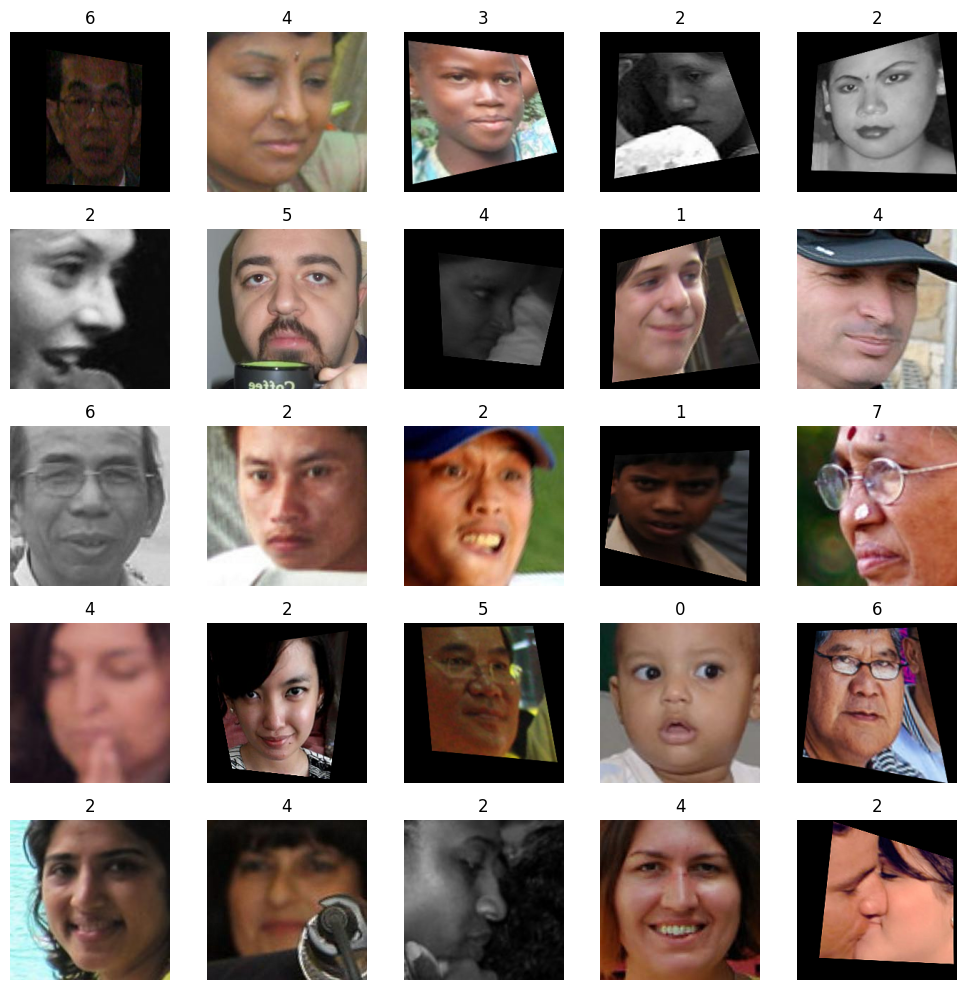

In [28]:
it = iter(train_dataset)
muestras = [next(it) for i in range(30)]
imgs = [np.array(m[0].permute(1, 2, 0)) for m in muestras]
cats = [m[1] for m in muestras]
cats = [m[1].item() for m in muestras]

imgs = [denormalize(m[0].permute(1, 2, 0)).numpy() for m in muestras]
muestra_imagenes(np.array(imgs), cats)

## Imagenes en el set de validación

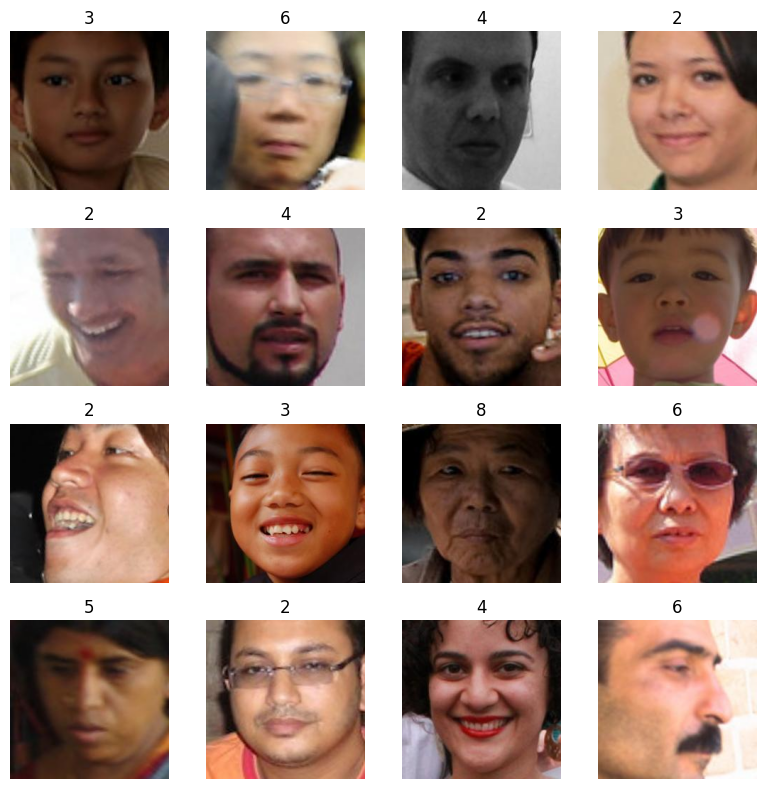

In [29]:
it = iter(val_dataset)
muestras = [next(it) for i in range(20)]
imgs = [np.array(m[0].permute(1, 2, 0)) for m in muestras]
cats = [m[1] for m in muestras]
cats = [m[1].item() for m in muestras]

imgs = [denormalize(m[0].permute(1, 2, 0)).numpy() for m in muestras]
muestra_imagenes(np.array(imgs), cats)

## Creamos los dataloaders para entrenamiento y validacion

In [26]:
entdl = DataLoader(train_dataset,
                   batch_size=256,
                   shuffle=True
                   )

it_entdl = iter(entdl)
lote = next(it_entdl)
print(f'Imágenes = {lote[0].shape}, Categorías = {lote[1].shape}')

Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])


In [32]:
for i,l in enumerate(entdl):
  if i > 10:
    break
  print(f'Lote {i}: Imágenes = {l[0].shape}, Categorías = {l[1].shape}')

Lote 0: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 1: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 2: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 3: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 4: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 5: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 6: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 7: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 8: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 9: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])
Lote 10: Imágenes = torch.Size([256, 3, 224, 224]), Categorías = torch.Size([256])


In [34]:
from collections import Counter

# Contador para almacenar la frecuencia de cada etiqueta
etiqueta_contador = Counter()

# Iterar sobre todos los lotes en el DataLoader
for images, labels in tqdm(entdl):
    # Contar las etiquetas en cada lote
    etiqueta_contador.update(labels.cpu().numpy())

print(f'Distribución de etiquetas en el DataLoader: {etiqueta_contador}')


100%|██████████| 339/339 [04:43<00:00,  1.20it/s]

Distribución de etiquetas en el DataLoader: Counter({2: 25598, 4: 19250, 5: 10744, 3: 10408, 1: 9103, 6: 6228, 7: 2779, 0: 1792, 8: 842})


## Imagenes en el dataloader de entrenamiento

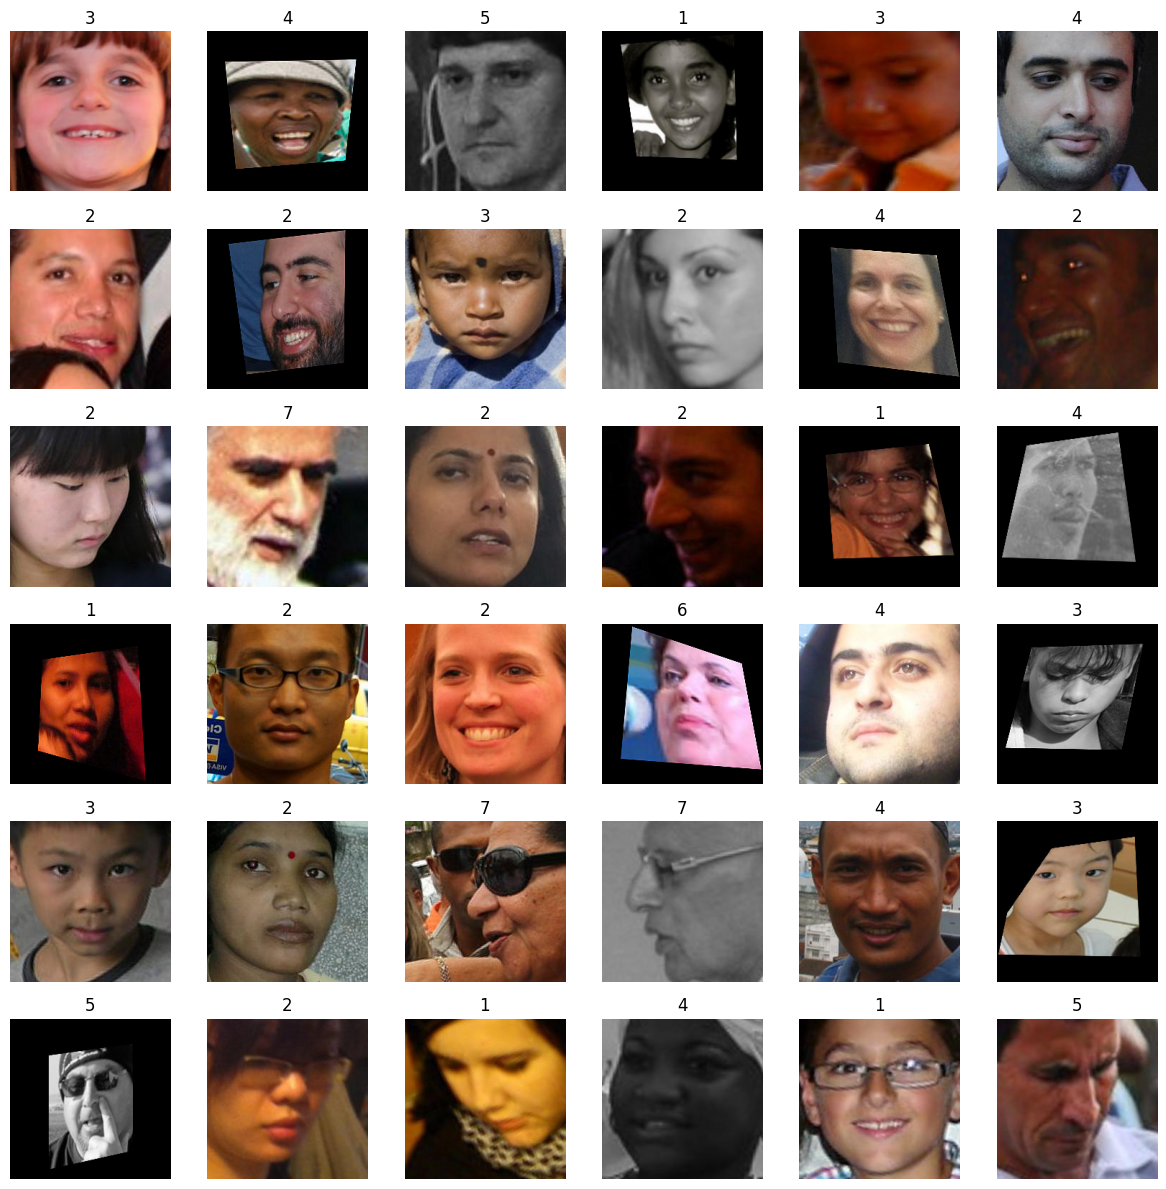

In [34]:
imgs_denorm = [denormalize(img.permute(1, 2, 0)).numpy() for img in lote[0][:40]]
muestra_imagenes(np.array(imgs_denorm), lote[1][:40].numpy())

In [27]:
valdl = DataLoader(val_dataset,
                   batch_size=256,
                   shuffle=True)

In [51]:
etiqueta_contador_val = Counter()
# Iterar sobre todos los lotes en el DataLoader
for images, labels in tqdm(valdl):
    # Contar las etiquetas en cada lote
    etiqueta_contador_val.update(labels.cpu().numpy())

print(f'Distribución de etiquetas en el Val DataLoader: {etiqueta_contador_val}')

100%|██████████| 43/43 [00:10<00:00,  3.95it/s]

Distribución de etiquetas en el Val DataLoader: Counter({2: 3300, 4: 2330, 3: 1356, 5: 1353, 1: 1181, 6: 796, 7: 321, 0: 199, 8: 118})


## Imagenes en el dataloader de validación

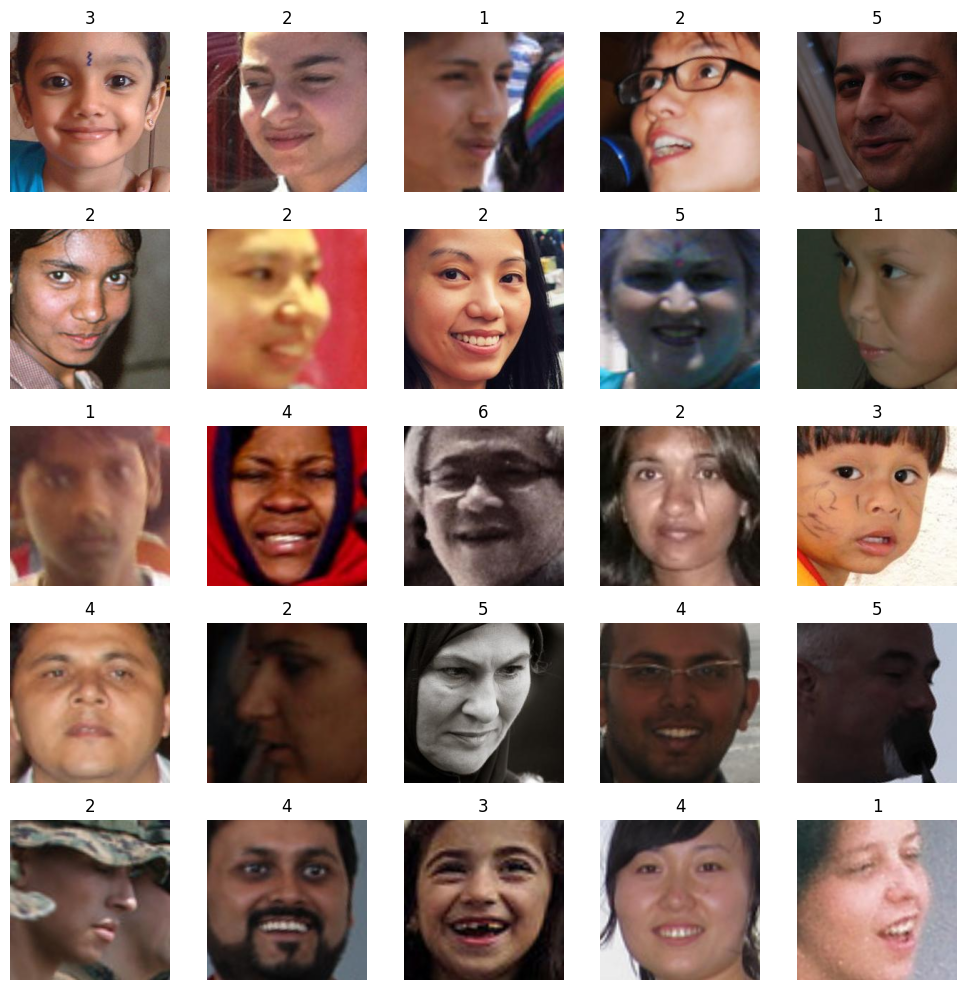

In [36]:
it_valdl = iter(valdl)
lote = next(it_valdl)
imgs_denorm = [denormalize(img.permute(1, 2, 0)).numpy() for img in lote[0][:30]]
muestra_imagenes(np.array(imgs_denorm), lote[1][:30].numpy())

## Definimos la funciones necesarias para el entrenamiento

In [28]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)

In [29]:
from torch.utils.tensorboard import SummaryWriter

def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

In [30]:
from sklearn.metrics import cohen_kappa_score

def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

def kappa_score(y_hat, y):
    # Convertir las predicciones y etiquetas a NumPy
    y_hat_np = y_hat.argmax(dim=-1).cpu().numpy()
    y_np = y.cpu().numpy()

    # Calcular el coeficiente Kappa
    kappa = cohen_kappa_score(y_np, y_hat_np)
    return kappa


In [31]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with torch.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso

In [32]:
def entrena(modelo, fp, metrica, opt, scheduler, entdl, valdl, disp, ckptpath, n_epocas=10, tbdir='runs/'):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {'perdida_ent': np.zeros(n_epocas),
            'perdida_val': np.zeros(n_epocas),
            metrica.__name__ + '_ent': np.zeros(n_epocas),
            metrica.__name__ + '_val': np.zeros(n_epocas)}

    tbwriter = SummaryWriter(tbdir)
    perdida_min = torch.inf
    mejor_modelo = copy.deepcopy(modelo)

    for e in range(n_epocas):
        modelo.train()
        progreso_ent = tqdm(entdl, desc=f'Época {e + 1}/{n_epocas}', leave=False)
        for p, (Xlote, ylote) in enumerate(progreso_ent):
            Xlote = Xlote.to(disp)
            ylote = ylote.to(disp)

            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)

            hist['perdida_ent'][e] += perdida_paso.item()
            hist[metrica.__name__ + '_ent'][e] += metrica_paso

            progreso_ent.set_postfix({
                'Perdida(E)': f'{hist["perdida_ent"][e]/(p+1):.4f}',
                f'{metrica.__name__}(E)': f'{hist[metrica.__name__ + "_ent"][e]/(p+1):.4f}'
            })

        modelo.eval()
        progreso_val = tqdm(valdl, desc='Validación', leave=False)
        with torch.no_grad():
            for p, (Xlote, ylote) in enumerate(progreso_val):
                Xlote = Xlote.to(disp)
                ylote = ylote.to(disp)

                y_hat = modelo(Xlote)

                perdida_val_paso = fp(y_hat, ylote).item()
                metrica_val_paso = metrica(y_hat, ylote)

                hist['perdida_val'][e] += perdida_val_paso
                hist[metrica.__name__ + '_val'][e] += metrica_val_paso

                progreso_val.set_postfix({
                    'Perdida(V)': f'{hist["perdida_val"][e]/(p+1):.4f}',
                    f'{metrica.__name__}(V)': f'{hist[metrica.__name__ + "_val"][e]/(p+1):.4f}'
                })

        hist['perdida_ent'][e] /= n_lotes_ent
        hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
        hist['perdida_val'][e] /= n_lotes_val
        hist[metrica.__name__ + '_val'][e] /= n_lotes_val

        if hist['perdida_val'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)
            perdida_min = hist['perdida_val'][e]

        # Actualizar el scheduler basado en la pérdida de validación
        scheduler.step(hist['perdida_val'][e])
        lr = scheduler.optimizer.param_groups[0]['lr']
        # Registrar los valores en TensorBoard
        registra_info_tboard(tbwriter, e, hist)

        print(f'\nÉpoca {e + 1}/{n_epocas}: '
              f'Perdida(E) = {hist["perdida_ent"][e]:.4f}, '
              f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.4f}, '
              f'Perdida(V) = {hist["perdida_val"][e]:.4f}, '
              f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.4f}',
              f"Tasa de aprendizaje en la época {e+1}: {lr}")

    return modelo, mejor_modelo, hist

In [43]:
from torch.optim import AdamW

ConvNeXt = ConvNeXt50(in_channels=3, n_clases=pd.Series(train_dataset.labels).nunique(), drop_path_rate=0.3).to(device)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.05)

opt = AdamW(ConvNeXt.parameters(),
           lr=1e-4,
           weight_decay=1e-2)

scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=2)

# Entrenamiento
Resnet, mejor_lenet, hist = entrena(ConvNeXt,
                                   perdida,
                                   exactitud,
                                   opt,
                                   scheduler,
                                   entdl,
                                   valdl,
                                   device,
                                   ckptpath,
                                   n_epocas=40,
                                   tbdir=LOGDIR)


Época 1/40: Perdida(E) = 1.9114, exactitud(E) = 0.2889, Perdida(V) = 1.8847, exactitud(V) = 0.2614 Tasa de aprendizaje en la época 1: 0.0001



Época 2/40: Perdida(E) = 1.8734, exactitud(E) = 0.2984, Perdida(V) = 1.8111, exactitud(V) = 0.3237 Tasa de aprendizaje en la época 2: 0.0001



Época 3/40: Perdida(E) = 1.8351, exactitud(E) = 0.3117, Perdida(V) = 1.7649, exactitud(V) = 0.3324 Tasa de aprendizaje en la época 3: 0.0001



Época 4/40: Perdida(E) = 1.8016, exactitud(E) = 0.3238, Perdida(V) = 1.7369, exactitud(V) = 0.3493 Tasa de aprendizaje en la época 4: 0.0001



Época 5/40: Perdida(E) = 1.7769, exactitud(E) = 0.3306, Perdida(V) = 1.6959, exactitud(V) = 0.3699 Tasa de aprendizaje en la época 5: 0.0001



Época 6/40: Perdida(E) = 1.7551, exactitud(E) = 0.3403, Perdida(V) = 1.6798, exactitud(V) = 0.3775 Tasa de aprendizaje en la época 6: 0.0001



Época 7/40: Perdida(E) = 1.7337, exactitud(E) = 0.3469, Perdida(V) = 1.6361, exactitud(V) = 0.3866 Tasa de aprendizaje en la época 7: 0.0001



Época 8/40: Perdida(E) = 1.7092, exactitud(E) = 0.3561, Perdida(V) = 1.6253, exactitud(V) = 0.3875 Tasa de aprendizaje en la época 8: 0.0001



Época 9/40: Perdida(E) = 1.6917, exactitud(E) = 0.3642, Perdida(V) = 1.6023, exactitud(V) = 0.3978 Tasa de aprendizaje en la época 9: 0.0001



Época 10/40: Perdida(E) = 1.6734, exactitud(E) = 0.3692, Perdida(V) = 1.5787, exactitud(V) = 0.4057 Tasa de aprendizaje en la época 10: 0.0001



Época 11/40: Perdida(E) = 1.6574, exactitud(E) = 0.3744, Perdida(V) = 1.5570, exactitud(V) = 0.4149 Tasa de aprendizaje en la época 11: 0.0001



Época 12/40: Perdida(E) = 1.6425, exactitud(E) = 0.3808, Perdida(V) = 1.5433, exactitud(V) = 0.4180 Tasa de aprendizaje en la época 12: 0.0001



Época 13/40: Perdida(E) = 1.6256, exactitud(E) = 0.3867, Perdida(V) = 1.5182, exactitud(V) = 0.4293 Tasa de aprendizaje en la época 13: 0.0001



Época 14/40: Perdida(E) = 1.6105, exactitud(E) = 0.3917, Perdida(V) = 1.4984, exactitud(V) = 0.4391 Tasa de aprendizaje en la época 14: 0.0001



Época 15/40: Perdida(E) = 1.5945, exactitud(E) = 0.3987, Perdida(V) = 1.4835, exactitud(V) = 0.4442 Tasa de aprendizaje en la época 15: 0.0001



Época 16/40: Perdida(E) = 1.5776, exactitud(E) = 0.4028, Perdida(V) = 1.4755, exactitud(V) = 0.4396 Tasa de aprendizaje en la época 16: 0.0001



Época 17/40: Perdida(E) = 1.5634, exactitud(E) = 0.4076, Perdida(V) = 1.4453, exactitud(V) = 0.4523 Tasa de aprendizaje en la época 17: 0.0001



Época 18/40: Perdida(E) = 1.5494, exactitud(E) = 0.4130, Perdida(V) = 1.4363, exactitud(V) = 0.4543 Tasa de aprendizaje en la época 18: 0.0001



Época 19/40: Perdida(E) = 1.5332, exactitud(E) = 0.4171, Perdida(V) = 1.4254, exactitud(V) = 0.4582 Tasa de aprendizaje en la época 19: 0.0001



Época 20/40: Perdida(E) = 1.5216, exactitud(E) = 0.4236, Perdida(V) = 1.4079, exactitud(V) = 0.4670 Tasa de aprendizaje en la época 20: 0.0001



Época 21/40: Perdida(E) = 1.5122, exactitud(E) = 0.4276, Perdida(V) = 1.3911, exactitud(V) = 0.4694 Tasa de aprendizaje en la época 21: 0.0001



Época 22/40: Perdida(E) = 1.4985, exactitud(E) = 0.4302, Perdida(V) = 1.3824, exactitud(V) = 0.4711 Tasa de aprendizaje en la época 22: 0.0001



Época 23/40: Perdida(E) = 1.4950, exactitud(E) = 0.4350, Perdida(V) = 1.3829, exactitud(V) = 0.4763 Tasa de aprendizaje en la época 23: 0.0001



Época 24/40: Perdida(E) = 1.4804, exactitud(E) = 0.4403, Perdida(V) = 1.3731, exactitud(V) = 0.4879 Tasa de aprendizaje en la época 24: 0.0001



Época 25/40: Perdida(E) = 1.4699, exactitud(E) = 0.4431, Perdida(V) = 1.3708, exactitud(V) = 0.4807 Tasa de aprendizaje en la época 25: 0.0001



Época 26/40: Perdida(E) = 1.4596, exactitud(E) = 0.4483, Perdida(V) = 1.3459, exactitud(V) = 0.4857 Tasa de aprendizaje en la época 26: 0.0001



Época 27/40: Perdida(E) = 1.4535, exactitud(E) = 0.4515, Perdida(V) = 1.3470, exactitud(V) = 0.4924 Tasa de aprendizaje en la época 27: 0.0001



Época 28/40: Perdida(E) = 1.4428, exactitud(E) = 0.4546, Perdida(V) = 1.3453, exactitud(V) = 0.4898 Tasa de aprendizaje en la época 28: 0.0001



Época 29/40: Perdida(E) = 1.4349, exactitud(E) = 0.4577, Perdida(V) = 1.3351, exactitud(V) = 0.4935 Tasa de aprendizaje en la época 29: 0.0001



Época 30/40: Perdida(E) = 1.4286, exactitud(E) = 0.4578, Perdida(V) = 1.3318, exactitud(V) = 0.4960 Tasa de aprendizaje en la época 30: 0.0001



Época 31/40: Perdida(E) = 1.4195, exactitud(E) = 0.4592, Perdida(V) = 1.3206, exactitud(V) = 0.4946 Tasa de aprendizaje en la época 31: 0.0001



Época 32/40: Perdida(E) = 1.4127, exactitud(E) = 0.4659, Perdida(V) = 1.3215, exactitud(V) = 0.4924 Tasa de aprendizaje en la época 32: 0.0001



Época 33/40: Perdida(E) = 1.4046, exactitud(E) = 0.4713, Perdida(V) = 1.3140, exactitud(V) = 0.5055 Tasa de aprendizaje en la época 33: 0.0001



Época 34/40: Perdida(E) = 1.3964, exactitud(E) = 0.4714, Perdida(V) = 1.3043, exactitud(V) = 0.5029 Tasa de aprendizaje en la época 34: 0.0001



Época 35/40: Perdida(E) = 1.3909, exactitud(E) = 0.4754, Perdida(V) = 1.3029, exactitud(V) = 0.5071 Tasa de aprendizaje en la época 35: 0.0001



Época 36/40: Perdida(E) = 1.3853, exactitud(E) = 0.4784, Perdida(V) = 1.3059, exactitud(V) = 0.5051 Tasa de aprendizaje en la época 36: 0.0001



Época 37/40: Perdida(E) = 1.3760, exactitud(E) = 0.4812, Perdida(V) = 1.2931, exactitud(V) = 0.5110 Tasa de aprendizaje en la época 37: 0.0001



Época 38/40: Perdida(E) = 1.3713, exactitud(E) = 0.4844, Perdida(V) = 1.2971, exactitud(V) = 0.5119 Tasa de aprendizaje en la época 38: 0.0001



Época 39/40: Perdida(E) = 1.3622, exactitud(E) = 0.4892, Perdida(V) = 1.2914, exactitud(V) = 0.5159 Tasa de aprendizaje en la época 39: 0.0001



Época 40/40: Perdida(E) = 1.3574, exactitud(E) = 0.4898, Perdida(V) = 1.2850, exactitud(V) = 0.5185 Tasa de aprendizaje en la época 40: 0.0001


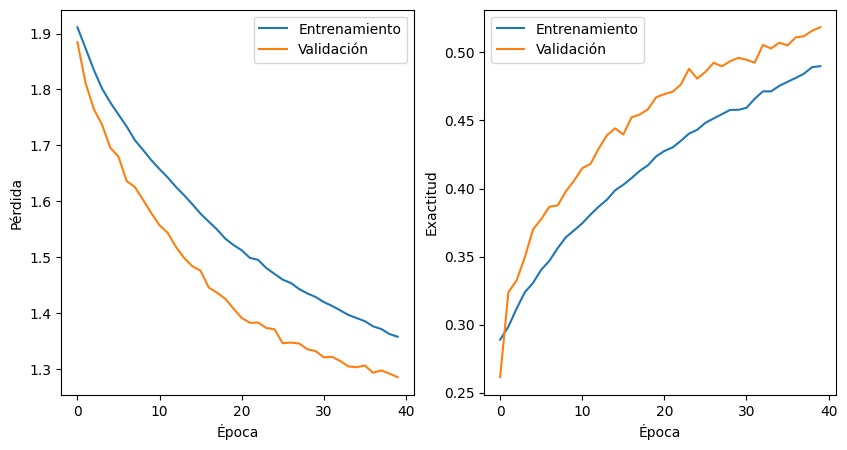

In [44]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

### -Pérdida: La gráfica de pérdida revela una tendencia descendente tanto en el entrenamiento como en la validación. A lo largo de las 40 épocas, no se detecta una separación significativa entre ambas curvas, lo que indica que no hay indicios tempranos de sobreajuste (overfitting).

### -Exactitud: La exactitud también mejora consistentemente, con la curva de validación ligeramente por encima de la de entrenamiento durante la mayor parte del proceso. Este comportamiento es generalmente indicativo de un buen ajuste, ya que el modelo generaliza correctamente sobre datos no vistos.

### -El entrenamiento terminó con una perdida en entrenamiento de 1.3574 y un accuracy de 0.4898, mientras que en validación se obtuvo una perdida de 1.2850 y un accuracy de 0.5185, cuando se había iniciado con valores de 2 para la perdida y 0.2 para el accuracy

### Antes de las 40 epocas no hay ningún signo de overfit, sin emabrgo, al seguir aumentando las epocas, el overfit se hacer más presente, las métricas de perdida y accuracy siguen mejorando en entrenamiento pero en validación empiezan a empeorar, razón por la cual se decide dejar solo un total de 40 epocas de entrenamieto, y de esta forma evitar el sobre ajuste, pero reduciendo la exactitud que se puede obtener. 

## APRENDIZAJE POR TRANSFERENCIA

In [38]:
modelo = tv.models.resnet50(weights = tv.models.ResNet50_Weights.IMAGENET1K_V1) #Usamos el modelo de ResNet50 con sus pesos pre entrenados

In [39]:
for p in modelo.parameters(): #Congelamos todas las capas
    p.requires_grad = False

In [40]:
modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
n_clases = pd.Series(train_dataset.labels).nunique()
modelo.fc = nn.Linear(2048, n_clases) #Realizamos la modificación en la ultima capa (capa lineal), la cual entrenaremos con base en nuestras etiquetas 

In [45]:
def entrena_transferencia(modelo,
                          fp,
                          metrica,
                          opt,
                          entdl,
                          valdl,
                          disp,
                          ckptpath,
                          n_epocas=10,
                          tbdir='runs/'):
    n_lotes_ent = len(entdl)
    n_lotes_val = len(valdl)

    hist = {
        'ent': {
            'perdida': np.zeros(n_epocas),
            metrica.__name__: np.zeros(n_epocas)
        },
        'val': {
            'perdida': np.zeros(n_epocas),
            metrica.__name__: np.zeros(n_epocas)
        }
    }

    tbwriter_ent = SummaryWriter(str(tbdir) + '/ent')
    tbwriter_val = SummaryWriter(str(tbdir) + '/val')

    perdida_min = torch.inf
    mejor_modelo = copy.deepcopy(modelo)

    for e in range(n_epocas):
        # Bucle de entrenamiento con barra de progreso
        progreso_ent = tqdm(entdl, desc=f'Época {e + 1}/{n_epocas}', leave=False)
        modelo.fc.train()
        for p, (Xlote, ylote) in enumerate(progreso_ent):
            Xlote = Xlote.to(disp)
            ylote = ylote.to(disp)

            # Llamada única a paso_ent
            perdida_paso, metrica_paso = paso_ent(modelo, fp, metrica, opt, Xlote, ylote)

            # Actualizar historial
            hist['ent']['perdida'][e] += perdida_paso.item()
            hist['ent'][metrica.__name__][e] += metrica_paso

            # Actualizar la barra de progreso
            progreso_ent.set_postfix({
                'Perdida(E)': f'{hist["ent"]["perdida"][e]/(p+1):.4f}',
                f'{metrica.__name__}(E)': f'{hist["ent"][metrica.__name__][e]/(p+1):.4f}'
            })

        # Bucle de validación con barra de progreso
        progreso_val = tqdm(valdl, desc='Validación', leave=False)
        modelo.fc.eval()
        with torch.no_grad():
            for p, (Xlote, ylote) in enumerate(progreso_val):
                Xlote = Xlote.to(disp)
                ylote = ylote.to(disp)

                y_hat = modelo(Xlote)

                # Calcular pérdida y métrica
                perdida_val_paso = fp(y_hat, ylote).item()
                metrica_val_paso = metrica(y_hat, ylote)

                # Actualizar historial
                hist['val']['perdida'][e] += perdida_val_paso
                hist['val'][metrica.__name__][e] += metrica_val_paso

                # Actualizar la barra de progreso
                progreso_val.set_postfix({
                    'Perdida(V)': f'{hist["val"]["perdida"][e]/(p+1):.4f}',
                    f'{metrica.__name__}(V)': f'{hist["val"][metrica.__name__][e]/(p+1):.4f}'
                })

        # Promediar las métricas al final de la época
        hist['ent']['perdida'][e] /= n_lotes_ent
        hist['ent'][metrica.__name__][e] /= n_lotes_ent
        hist['val']['perdida'][e] /= n_lotes_val
        hist['val'][metrica.__name__][e] /= n_lotes_val

        # Guardar el mejor modelo basado en la pérdida de validación
        if hist['val']['perdida'][e] < perdida_min:
            mejor_modelo.load_state_dict(modelo.state_dict())
            guarda_ckpt(ckptpath, modelo, e, opt)
            perdida_min = hist['val']['perdida'][e]

        # Registrar en TensorBoard
        registra_info_tboard(tbwriter_ent, e, hist['ent'])
        registra_info_tboard(tbwriter_val, e, hist['val'])

        # Imprimir resultados de la época
        print(f'\nÉpoca {e + 1}: '
              f'Perdida(E) = {hist["ent"]["perdida"][e]:.3f}, '
              f'{metrica.__name__}(E) = {hist["ent"][metrica.__name__][e]:.3f}, '
              f'Perdida(V) = {hist["val"]["perdida"][e]:.3f}, '
              f'{metrica.__name__}(V) = {hist["val"][metrica.__name__][e]:.3f}')

    return modelo, mejor_modelo, hist

In [47]:
from torch.optim import Adam
LOGDIR = current_dir / 'logs' / 'Faces'
ckptpath = LOGDIR / 'ResNet18_T.pt'
modelo.to(device)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.01)
opt = Adam(modelo.parameters(),
           lr=0.0001)

modelo, mejor_modelo, hist = entrena_transferencia(modelo,
                                                   perdida,
                                                   exactitud,
                                                   opt,
                                                   entdl,
                                                   valdl,
                                                   device,
                                                   ckptpath,
                                                   n_epocas=20,
                                                   tbdir = LOGDIR)


Época 1: Perdida(E) = 1.730, exactitud(E) = 0.335, Perdida(V) = 1.605, exactitud(V) = 0.381



Época 2: Perdida(E) = 1.587, exactitud(E) = 0.378, Perdida(V) = 1.546, exactitud(V) = 0.400



Época 3: Perdida(E) = 1.547, exactitud(E) = 0.390, Perdida(V) = 1.523, exactitud(V) = 0.400



Época 4: Perdida(E) = 1.527, exactitud(E) = 0.396, Perdida(V) = 1.506, exactitud(V) = 0.415



Época 5: Perdida(E) = 1.515, exactitud(E) = 0.399, Perdida(V) = 1.494, exactitud(V) = 0.419



Época 6: Perdida(E) = 1.503, exactitud(E) = 0.404, Perdida(V) = 1.489, exactitud(V) = 0.419



Época 7: Perdida(E) = 1.497, exactitud(E) = 0.407, Perdida(V) = 1.481, exactitud(V) = 0.415



Época 8: Perdida(E) = 1.491, exactitud(E) = 0.406, Perdida(V) = 1.481, exactitud(V) = 0.410



Época 9: Perdida(E) = 1.485, exactitud(E) = 0.409, Perdida(V) = 1.471, exactitud(V) = 0.423



Época 10: Perdida(E) = 1.481, exactitud(E) = 0.409, Perdida(V) = 1.467, exactitud(V) = 0.421



Época 11: Perdida(E) = 1.478, exactitud(E) = 0.410, Perdida(V) = 1.466, exactitud(V) = 0.421



Época 12: Perdida(E) = 1.473, exactitud(E) = 0.414, Perdida(V) = 1.461, exactitud(V) = 0.424



Época 13: Perdida(E) = 1.469, exactitud(E) = 0.414, Perdida(V) = 1.462, exactitud(V) = 0.419



Época 14: Perdida(E) = 1.466, exactitud(E) = 0.416, Perdida(V) = 1.456, exactitud(V) = 0.424



Época 15: Perdida(E) = 1.464, exactitud(E) = 0.417, Perdida(V) = 1.456, exactitud(V) = 0.418



Época 16: Perdida(E) = 1.462, exactitud(E) = 0.417, Perdida(V) = 1.453, exactitud(V) = 0.423



Época 17: Perdida(E) = 1.460, exactitud(E) = 0.418, Perdida(V) = 1.449, exactitud(V) = 0.426



Época 18: Perdida(E) = 1.458, exactitud(E) = 0.419, Perdida(V) = 1.452, exactitud(V) = 0.420



Época 19: Perdida(E) = 1.457, exactitud(E) = 0.419, Perdida(V) = 1.445, exactitud(V) = 0.425



Época 20: Perdida(E) = 1.453, exactitud(E) = 0.422, Perdida(V) = 1.442, exactitud(V) = 0.426


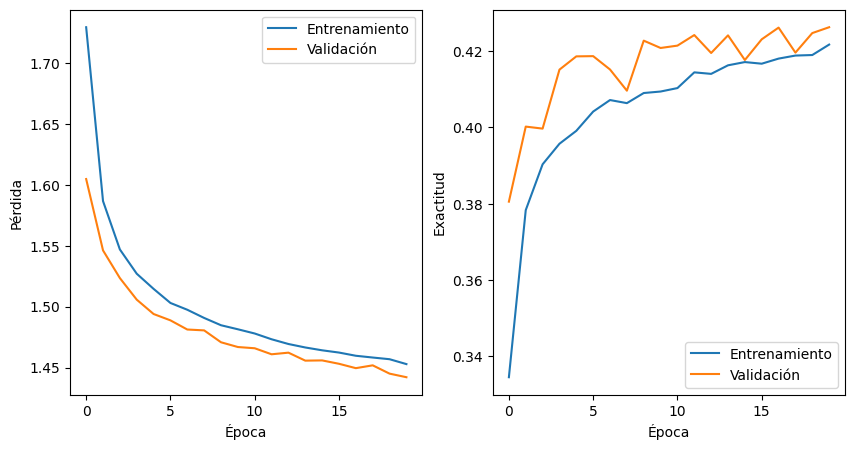

In [49]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

### El modelo preentrenado con Transfer Learning presentó valores iniciales de pérdida y exactitud significativamente mejores en comparación con el modelo entrenado desde cero. En solo 20 épocas, se alcanzaron métricas de rendimiento muy similares a las obtenidas con un modelo entrenado desde el inicio en un mayor número de épocas.
### Estos resultados evidencian que el uso de Transfer Learning puede ser altamente beneficioso en tareas específicas, ya que acelera el proceso de convergencia del modelo. Al aprovechar pesos previamente aprendidos de un dominio relacionado, el modelo no necesita comenzar el proceso de aprendizaje desde cero, lo que permite una reducción considerable en el tiempo de entrenamiento sin comprometer el desempeño final en términos de métricas de exactitud y pérdida.

## FINE TUNING

In [34]:
modelo_fine = tv.models.resnet18(weights = tv.models.ResNet18_Weights.IMAGENET1K_V1)

In [35]:
#Congelamos las primeras capas del modelo y descongelamos las ultimas 
for name, param in modelo_fine.named_parameters():
    if name.startswith('conv1') or name.startswith('layer1') or name.startswith('layer2'):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [42]:
modelo_fine.fc = nn.Linear(512, n_clases)

In [43]:
modelo_fine.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:

LOGDIR = current_dir / 'logs' / 'Faces' / 'Fine'
ckptpath = LOGDIR / 'ResNet50_FT.pt'
modelo_fine.to(device)
perdida = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.08)

opt = AdamW(modelo_fine.parameters(),
           lr=0.0001)

modelo, mejor_modelo, hist = entrena_transferencia(modelo_fine,
                                                   perdida,
                                                   exactitud,
                                                   opt,
                                                   entdl,
                                                   valdl,
                                                   device,
                                                   ckptpath,
                                                   n_epocas=10,
                                                   tbdir = LOGDIR)


Época 1: Perdida(E) = 1.512, exactitud(E) = 0.445, Perdida(V) = 1.393, exactitud(V) = 0.495



Época 2: Perdida(E) = 1.357, exactitud(E) = 0.513, Perdida(V) = 1.338, exactitud(V) = 0.525



Época 3: Perdida(E) = 1.308, exactitud(E) = 0.537, Perdida(V) = 1.302, exactitud(V) = 0.544



Época 4: Perdida(E) = 1.274, exactitud(E) = 0.553, Perdida(V) = 1.275, exactitud(V) = 0.550



Época 5: Perdida(E) = 1.244, exactitud(E) = 0.571, Perdida(V) = 1.256, exactitud(V) = 0.557



Época 6: Perdida(E) = 1.218, exactitud(E) = 0.583, Perdida(V) = 1.293, exactitud(V) = 0.549



Época 7: Perdida(E) = 1.193, exactitud(E) = 0.596, Perdida(V) = 1.306, exactitud(V) = 0.540



Época 8: Perdida(E) = 1.174, exactitud(E) = 0.608, Perdida(V) = 1.250, exactitud(V) = 0.570



Época 9: Perdida(E) = 1.148, exactitud(E) = 0.625, Perdida(V) = 1.280, exactitud(V) = 0.553



Época 10: Perdida(E) = 1.129, exactitud(E) = 0.634, Perdida(V) = 1.282, exactitud(V) = 0.560


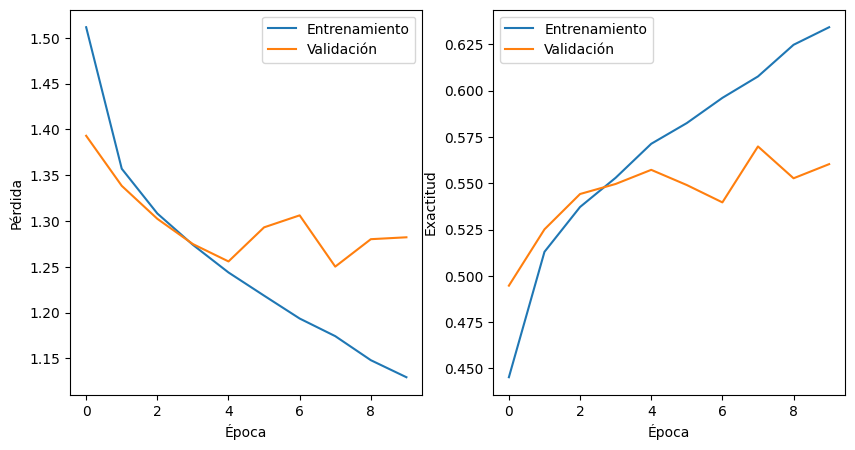

In [47]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['ent']['perdida'], label='Entrenamiento')
axs[0].plot(hist['val']['perdida'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['ent']['exactitud'], label='Entrenamiento')
axs[1].plot(hist['val']['exactitud'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

### En este experimento, se congelaron las primeras dos capas de la red ResNet18 preentrenada con ImageNet y se realizó fine-tuning con solo 10 épocas de entrenamiento. A pesar del corto número de épocas, comenzamos a observar signos de sobreajuste (overfitting), similar a lo observado durante el entrenamiento desde cero de la arquitectura ConvNeXt. Esto es evidente en el comportamiento de las métricas de validación, que empiezan a empeorar a medida que las épocas progresan, mientras que las métricas de entrenamiento continúan mejorando.

### El sobreajuste observado en las primeras épocas de entrenamiento puede estar relacionado con la naturaleza del dataset FairFaces, en particular para la tarea de clasificación por grupo etario. Un análisis preliminar del dataset reveló un marcado desbalance entre las clases, lo que sugiere que el modelo podría estar sobreajustándose a las clases mayoritarias, mientras tiene dificultades para generalizar en las clases menos representadas. Este desbalance es tan significativo que incluso el uso de técnicas como el submuestreo o sobremuestreo podría no ser suficiente para mejorar la generalización del modelo.

### En términos generales, el fine-tuning mostró una mejora rápida en las métricas de pérdida y exactitud tanto para el conjunto de entrenamiento como para el de validación. Al iniciar el entrenamiento con pesos preentrenados, las métricas comienzan con valores relativamente altos, lo que indica que el modelo ha retenido una representación útil de las características aprendidas en el conjunto de datos ImageNet. Esto reduce significativamente el tiempo de entrenamiento, ya que no es necesario recalcular ni ajustar los pesos de las capas congeladas durante el backpropagation.

## **CONCLUSIONES**

### **ENTRENAMIENTO DESDE 0**
### El entrenamiento desde cero mostró una mejora constante en la pérdida y la exactitud a lo largo de 40 épocas. Sin embargo, el tiempo de entrenamiento fue mayor debido a la necesidad de que el modelo aprenda las características desde el inicio.
### A pesar de no haber signos de sobreajuste hasta la época 40, se decidió detener el entrenamiento en este punto para evitar una posible degradación del rendimiento en validación, aunque esto limitó la exactitud que se podría haber obtenido con más épocas.

### **Transfer Learning**
### El Transfer Learning proporcionó una ventaja clara al iniciar con métricas de pérdida y exactitud mucho mejores en comparación con el entrenamiento desde cero.
### Se logró una convergencia en solo 20 épocas, con una diferencia mínima entre las métricas de entrenamiento y validación, lo que sugiere que el modelo generalizó bien a los datos de validación.
### El Transfer Learning aceleró significativamente el proceso de aprendizaje, demostrando que es una opción eficaz cuando se dispone de un modelo preentrenado en tareas similares.

### **Fine-Tuning** 
### El Fine-Tuning mostró una mejora más rápida en comparación con el entrenamiento desde cero y Transfer Learning puro, alcanzando mejores resultados en un menor número de épocas.
### A partir de la época 6, se empezaron a notar signos de sobreajuste, ya que las métricas de validación dejaron de mejorar de manera significativa y mostraron una ligera fluctuación.
### A pesar de estos signos tempranos de sobreajuste, el Fine-Tuning resultó en un rendimiento superior en términos de exactitud en entrenamiento y validación en comparación con los otros enfoques.